# Quantum Approximation Optimization Algorithm (QAOA)

## Overview

QAOA is a hybrid classical-quantum algorithm that combines quantum circuits, and classical optimization of those circuits. In this tutorial, we utilize QAOA to solve the maximum cut (Max-Cut) combinatorial optimization problem, as proposed by [Farhi, Goldstone, and Gutmann (2014)](https://arxiv.org/abs/1411.4028).

## Max-Cut Problem

In graph theory, a graph is composed of $n$ nodes, also known as vertices, and $m$ edges that connect the nodes. Note that there is not necessarily a link between any pair of nodes. Those $n$ nodes are divided into two sets. The number of edges that are cut by a partition/partitions of the nodes is what is going to be maximized.

As illustrated in the graph on the left below, a graph consists of nodes (or vertices) represented by grey circles, and edges, which are black lines that connect the nodes. Max-Cut problem is to find the maximum number of cut when nodes are divided into two set. 

For instance, in the right graph, nodes 0 and 1 are in set 0 (light blue), and nodes 2 and 3 are in set 1 (red). If we partition the nodes between these two sets, it will cut two edges (colored pink). Therefore, the number of cut edges in this case is 2. Basically, to find the maximum cut, we need to find the maximum number of edges where the corresponding nodes belong to different sets.

If we write down the set numbers that follow the node sequence, we can represent this instance as a bit string "0011". Since switching the names of the sets doesn't influence the results, the bit string "1100" gives the same number of edge cut. In general, we can use a binary string of length $n$ to represent a partition of $n$ nodes into two disjoint sets. This representation is commonly used in graph theory and combinatorial optimization, and it enables us to apply various computational techniques, including classical and quantum algorithms, to solve problems such as Max-Cut.

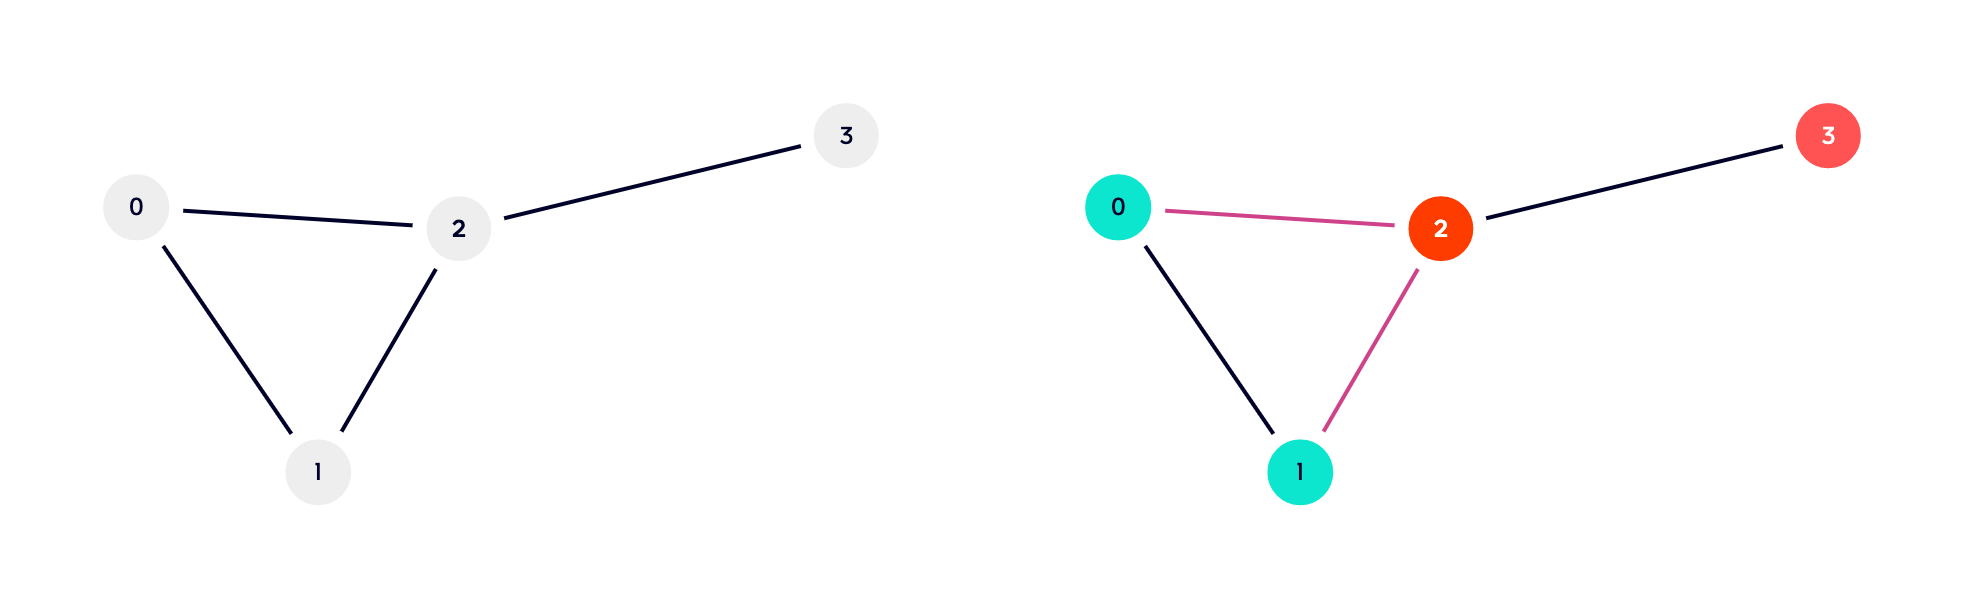

The Max-Cut problem is a NP-complete problem. Classically, one way to approach this problem is to test every possible bit string, which takes an exponential amount of time as the number of nodes, denoted by $n$, grows. Specifically, for $n$ nodes, there are $2^n$ combinations to test. However, recent advancements in quantum computing offer a more efficient way to solve this problem, where $n$ qubits are used to represent $n$ nodes. Nodes are divided according to the energy level of the qubits.

A cost (objective) function of the $\alpha$-th edge (which connects $j$-th and $k$-th nodes) is defined

$$C_\alpha=\frac12(1-\sigma_z^j\sigma_z^k)$$

When $C_\alpha = 1$, the $\alpha$-th is accounted a cut edge. It will happen if and only if $j$-th and $k$-th nodes are in different set. The total number of edge cut is written as

$$ C(z)=\sum_\alpha^mC_\alpha(z)$$

where $z = z_1z_2 . . . z_n$ is the bit string. Max-Cut asks for a string $z$ for which $C(z)$ is maximized. This problem is equivlant to finding the ground state of a cost Hamiltonian

$$H_C = \frac{1}{2} \sum_{i,j} \sigma^{j}_{z} \sigma^{k}_{z}$$

## QAOA for Max-Cut

The Quantum Approximate Optimization Algorithm (QAOA) utilizes a parameterized quantum circuit ([PQC](https://tensorcircuit.readthedocs.io/en/latest/textbook/chap5.html?highlight=变分)) to generate a quantum state that represents a potential solution to the Max Cut problem. The initial state, denoted as $|s\rangle$, is a uniform superposition over computational basis states.

$$|s\rangle=\frac{1}{\sqrt{2^n}}\sum_z|z\rangle$$

This state is then evolved by a unitary operator that consists of $q$ layers, denoted as

$$U(\vec{\beta}, \vec{\gamma}) = V_{p}U_{p} \cdots V_{1}U_{1},$$

where $U_{j}= e^{-i\gamma_{j}H_{C}}$ and $V_{j}= e^{-i \beta_{j} H_m}$. $H_C$ is the cost Hamiltonian introduced in previous section and the mixer Hamiltonian $H_m=\sum_j\sigma^j_x$ is used to mix the quantum state to explore different solutions. The unitary operator is parameterized by $2p$ angle parameters $\gamma_1\gamma_2 \dots\gamma_p=\gamma$ and $\beta_1\beta_2 \dots \beta_p=\beta$. It is worth noting that $\gamma$ is restricted to lie between $0$ and $2\pi$, and $\beta$ is restricted to lie between $0$ and $\pi$ due to the integer eigenvalues of $H_C$.

It is important and also tricky to find a proper $p$. As introduced by [Farhi, Goldstone, and Gutmann (2014)](https://arxiv.org/abs/1411.4028), $p$ should be equal to the maximum steps between any pair of nodes. For example, in the graph above, the max steps are found between node 3 and node 1 or 0, and this number is 2. Therefore, a 2-layer PQC should be used.

Begin with a set of initial parameters, the quantum state is calculate using the PQC and then the expected value of the cost Hamiltonian is calculated. A classical optimizer is then used to vary the parameters until a lower exptected value is found. This process is iterated a certain number of times, and the lowest expected value is approximated as the ground state energy of the cost Hamiltonian. By using the parameters that correspond to the lowest expected value, an approximate solution to the Max-Cut problem can be obtained.

In summary, a general QAOA algorithm follows these steps:

1. Define the cost fucntion according to the problem.

2. Define the parameterized quantum circuit with cost Hamiltonian and mixer Hamiltonian.

3. Define a group of initial parameters.

4. calculate the cost function of this group of parameters.

5. If a lower cost is found, accept it. Otherwise, keep the previously found cost.

6. Find a new group of parameters with an optimizer.

7. Repreat procedures 4-6 for given times. Then output the lowest cost and corresponding parameters.

## The code

In [89]:
import tensorcircuit as tc
import tensorflow as tf
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
import random

K = tc.set_backend("tensorflow")

nlayers = 3  # the number of layers
ncircuits = 6  # two circuits with different initial parameters are going to be optimized at the same time
nnodes = 8 # the number of nodes

### Define the Graph

The degree of a graph is defined as the maximum number of edges connected to single nodes. For example, the graph below has a fixed degree of 3.

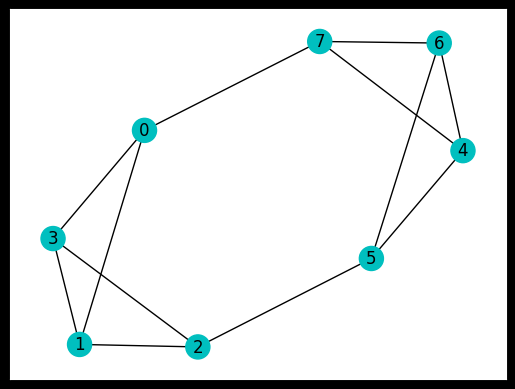

In [90]:
# a graph instance
# each node is connected to three nodes
# for example, node 0 is connected to nodes 1,7,3
example_graph_dict = {
    0: {1: {"weight": 1.0}, 7: {"weight": 1.0}, 3: {"weight": 1.0}},
    1: {0: {"weight": 1.0}, 2: {"weight": 1.0}, 3: {"weight": 1.0}},
    2: {1: {"weight": 1.0}, 3: {"weight": 1.0}, 5: {"weight": 1.0}},
    3: {1: {"weight": 1.0}, 2: {"weight": 1.0}, 0: {"weight": 1.0}},
    4: {7: {"weight": 1.0}, 6: {"weight": 1.0}, 5: {"weight": 1.0}},
    5: {6: {"weight": 1.0}, 4: {"weight": 1.0}, 2: {"weight": 1.0}},
    6: {7: {"weight": 1.0}, 4: {"weight": 1.0}, 5: {"weight": 1.0}},
    7: {4: {"weight": 1.0}, 6: {"weight": 1.0}, 0: {"weight": 1.0}},
}
pos = nx.spring_layout(nx.to_networkx_graph(example_graph_dict))
colors = ['c' for key in example_graph_dict.items()]

# convert to a NetworkX graph
example_graph = nx.to_networkx_graph(example_graph_dict) 
nx.draw_networkx(example_graph, with_labels=True, node_color=colors, pos=pos)
ax = plt.gca()
ax.set_facecolor('w')

### Parameterized Quantum Circuit (PQC)

In [91]:
def QAOAansatz(params, g=example_graph, return_circuit=False):
    n = len(g.nodes)  # the number of nodes
    c = tc.Circuit(n)
    for i in range(n):
        c.H(i)
        
    # PQC
    for j in range(nlayers):
        # U_j
        for e in g.edges:
            c.exp1(
                e[0],
                e[1],
                unitary=tc.gates._zz_matrix,
                theta=g[e[0]][e[1]].get("weight", 1.0) * params[2 * j],
            )
        # V_j
        for i in range(n):
            c.rx(i, theta=params[2 * j + 1])
    
    # whether to return the circuit
    if return_circuit is True:
        return c

    # calculate the loss function
    loss = 0.0
    for e in g.edges:
        loss += c.expectation_ps(z=[e[0], e[1]]) * g[e[0]][e[1]].get("weight", 1.0)

    return K.real(loss)

### Optimization

Here, several circuits with different initial parameters are optimized/trained at the same time.

Optimizers are used to find the minimum value.

In [92]:
# use vvag to get the losses and gradients with different random circuit instances
QAOA_vvag = K.jit(tc.backend.vvag(QAOAansatz, argnums=0, vectorized_argnums=0), static_argnums=(1, 2))

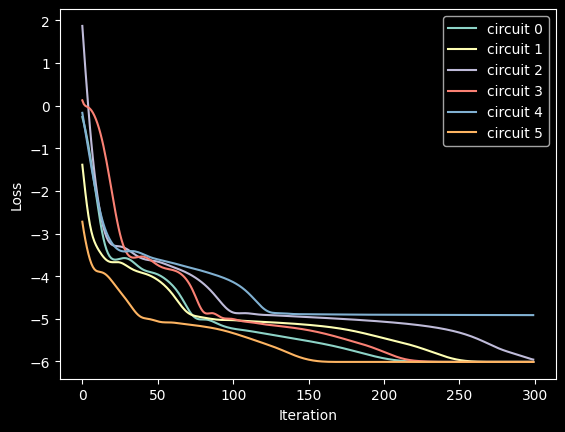

In [93]:
params = K.implicit_randn(
    shape=[ncircuits, 2 * nlayers], stddev=0.1
)  # initial parameters
opt = K.optimizer(tf.keras.optimizers.Adam(1e-2))

list_of_loss = [[] for i in range(ncircuits)]

for i in range(300):
    loss, grads = QAOA_vvag(params, example_graph)
    params = opt.update(grads, params)  # gradient descent

    # visualise the progress
    clear_output(wait=True)
    list_of_loss = np.hstack((list_of_loss, K.numpy(loss)[:, np.newaxis]))
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    for index in range(ncircuits):
        plt.plot(range(i+1), list_of_loss[index])
    legend = ['circuit %d' %leg for leg in range(ncircuits)]
    plt.legend(legend)
    plt.show()

### Results

After inputing the optimized parameters back to the ansatz circuit, we can measure the probablitiy distribution of the quantum states. The states with highest probability are supposed to be the ones corresponding to Max Cut.

In [94]:
# print all results
for num_circuit in range(ncircuits):
    c = QAOAansatz(params=params[num_circuit], g=example_graph, return_circuit=True)
    loss = QAOAansatz(params=params[num_circuit], g=example_graph)

    # find the states with max probabilities
    probs = K.numpy(c.probability()).round(decimals=4)
    index = np.where(probs==max(probs))[0]
    states = []
    for i in index:
        states.append(f'{bin(i)[2:]:0>{c._nqubits}}')
    print("Circuit #%d" %num_circuit)
    print('cost:', K.numpy(loss), '\nbit strings:', states, "\n")

Circuit #0
cost: -6.0114803 
bit strings: ['01010101', '10101010'] 

Circuit #1
cost: -6.0112667 
bit strings: ['01010101', '10101010'] 

Circuit #2
cost: -5.96354 
bit strings: ['01010101', '10101010'] 

Circuit #3
cost: -6.011477 
bit strings: ['01010101', '10101010'] 

Circuit #4
cost: -4.913675 
bit strings: ['01010101', '10101010'] 

Circuit #5
cost: -6.011479 
bit strings: ['01010101', '10101010'] 



Based on the results, quantum states with the highest probabilities are $\ket{01010101}$ and $\ket{10101010}$. This outcome aligns with our intuition, as swapping the labels of the groups would have an impact on the final result.

The network plot corresponding to $\ket{01010101}$ is:

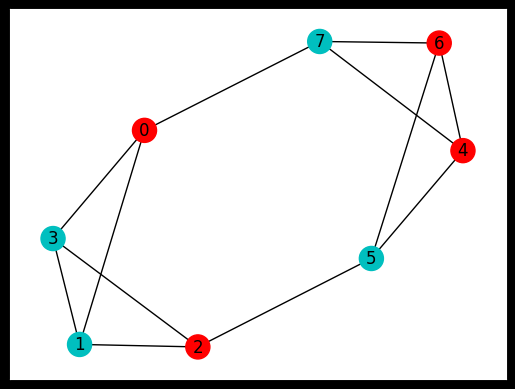

In [95]:
colors = ["r" if states[0][i] == '0' else "c" for i in range(nnodes)]
nx.draw_networkx(example_graph, with_labels=True, node_color=colors, pos=pos)
ax = plt.gca()
ax.set_facecolor('w')

## Classical Method

In classial method, all situation will be checked one-by-one (brutal force). 

In [96]:
def classical_solver(graph):
    num_nodes = len(graph)
    max_cut = [0]
    best_case = [0] # "01" series with max cut
    for i in range(2**num_nodes):
        case = f'{bin(i)[2:]:0>{num_nodes}}'
        cat1, cat2 = [], []
        for j in range(num_nodes):
            if str(case)[j] == '0':
                cat1.append(j)
            else:
                cat2.append(j)

        # calculate the cost function
        cost = 0
        for node1 in cat1:
            for node2 in cat2:
                if graph[node1].get(node2):
                    cost += graph[node1][node2]["weight"]
        cost = round(cost, 4) # elimate minor error
        if max_cut[-1] <= cost:
            max_cut.append(cost)
            best_case.append(case)
    
    # optimal cases maybe more than 1, but they are all at the end
    index = max_cut.index(max_cut[-1])
    
    return max_cut[-1], best_case[index:]
            
max_cut, best_case = classical_solver(example_graph_dict)
print('bit string:', best_case, '\nmax cut:', max_cut)

bit string: ['01010101', '10101010'] 
max cut: 10.0


## Weighted Max-Cut Problem

When an edge is cut, the total cost increase a certain number instead of 1, we say that this edge has a "weight".

Let's define a graph with random weights:

In [97]:
weighted_graph_dict = {
    0: {1: {"weight": 0.1756}, 7: {"weight": 2.5664}, 3: {"weight": 1.8383}},
    1: {0: {"weight": 0.1756}, 2: {"weight": 2.2142}, 3: {"weight": 4.7169}},
    2: {1: {"weight": 2.2142}, 3: {"weight": 2.0984}, 5: {"weight": 0.1699}},
    3: {1: {"weight": 4.7169}, 2: {"weight": 2.0984}, 0: {"weight": 1.8383}},
    4: {7: {"weight": 0.9870}, 6: {"weight": 0.0480}, 5: {"weight": 4.2509}},
    6: {7: {"weight": 4.7528}, 4: {"weight": 0.0480}, 5: {"weight": 2.2879}},
    5: {6: {"weight": 2.2879}, 4: {"weight": 4.2509}, 2: {"weight": 0.1699}},
    7: {4: {"weight": 0.9870}, 6: {"weight": 4.7528}, 0: {"weight": 2.5664}},  
}

weighted_graph = nx.to_networkx_graph(weighted_graph_dict) 

The classical algorithm is used to find the corresponding maximum cut

In [98]:
max_cut, best_case = classical_solver(weighted_graph_dict)
print('bit string:', best_case, '\nmax cut:', max_cut)

bit string: ['00010101', '11101010'] 
max cut: 23.6685


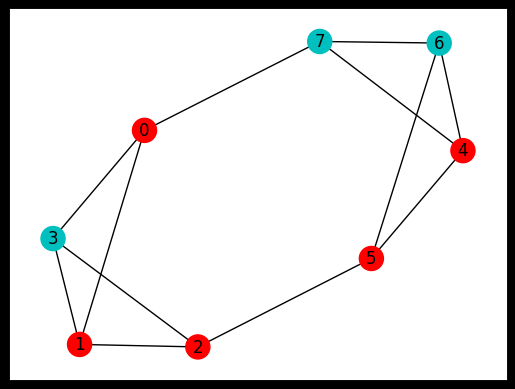

In [99]:
colors = ["r" if best_case[0][i] == '0' else "c" for i in range(nnodes)]
weighted_graph = nx.to_networkx_graph(weighted_graph_dict) 
nx.draw_networkx(weighted_graph, with_labels=True, node_color=colors, pos=pos)
ax = plt.gca()
ax.set_facecolor('w')

The quantum algorithm is then used, and the same result is supposed to be found.

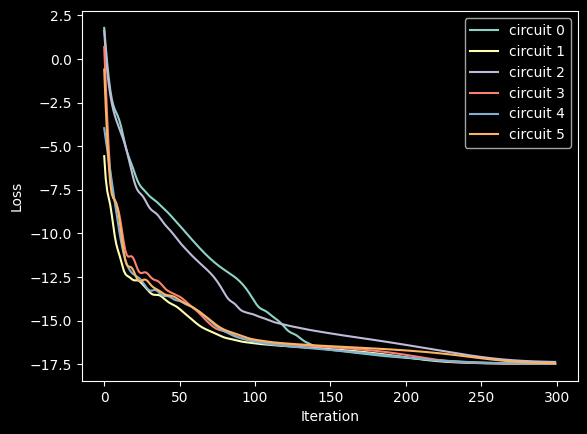

In [100]:
QAOA_vvag = K.jit(tc.backend.vvag(QAOAansatz, argnums=0, vectorized_argnums=0), static_argnums=(1, 2))
params = K.implicit_randn(
    shape=[ncircuits, 2 * nlayers], stddev=0.1
)  # initial parameters
opt = K.optimizer(tf.keras.optimizers.Adam(1e-2))

list_of_loss = [[] for i in range(ncircuits)]

for i in range(300):
    loss, grads = QAOA_vvag(params, weighted_graph)
    params = opt.update(grads, params)  # gradient descent

    # visualise the progress
    clear_output(wait=True)
    list_of_loss = np.hstack((list_of_loss, K.numpy(loss)[:, np.newaxis]))
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    for index in range(ncircuits):
        plt.plot(range(i+1), list_of_loss[index])
    legend = ['circuit %d' %leg for leg in range(ncircuits)]
    plt.legend(legend)
    plt.show()

In [101]:
# print all results
for num_circuit in range(ncircuits):
    c = QAOAansatz(params=params[num_circuit], g=weighted_graph, return_circuit=True)
    loss = QAOAansatz(params=params[num_circuit], g=weighted_graph)

    # find the states with max probabilities
    probs = K.numpy(c.probability()).round(decimals=4)
    index = np.where(probs==max(probs))[0]
    states = []
    for i in index:
        states.append(f'{bin(i)[2:]:0>{c._nqubits}}')
    print("Circuit #%d" %num_circuit)
    print('cost:', K.numpy(loss), '\nbit strings:', states, "\n")

Circuit #0
cost: -17.48183 
bit strings: ['00010101', '11101010'] 

Circuit #1
cost: -17.487226 
bit strings: ['00010101', '11101010'] 

Circuit #2
cost: -17.374956 
bit strings: ['00110101', '11001010'] 

Circuit #3
cost: -17.486227 
bit strings: ['00010101', '11101010'] 

Circuit #4
cost: -17.480951 
bit strings: ['00010101', '11101010'] 

Circuit #5
cost: -17.452002 
bit strings: ['00010101', '11101010'] 



In [102]:
tc.about()

OS info: macOS-13.3.1-arm64-arm-64bit
Python version: 3.10.10
Numpy version: 1.23.2
Scipy version: 1.10.1
Pandas version: 2.0.1
TensorNetwork version: 0.4.6
Cotengra is not installed
TensorFlow version: 2.12.0
TensorFlow GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow CUDA infos: {'is_cuda_build': False, 'is_rocm_build': False, 'is_tensorrt_build': False}
Jax is not installed
JaxLib is not installed
PyTorch is not installed
Cupy is not installed
Qiskit version: 0.23.3
Cirq is not installed
